In [1]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),    
)

In [3]:
# Define the batchs
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y {y.shape} {y.dtype}")
    break    

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y torch.Size([64]) torch.int64


In [4]:
# Move operations to GPU or MPS if available
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


In [5]:
# Define the model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [6]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
# makes prediction, backpropagates the prediction error and optimize
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss_value = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        loss_value.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d} / {size:>5d}]")
    return loss_value

# check the model performance against the test dataset
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")    

epochs = 10
loss_total = []
for t in range(epochs):
    print()
    loss_array = train(train_dataloader, model, loss_fn, optimizer)
    loss_total.append(loss_array)
    test(test_dataloader, model, loss_fn)
print("Done!")

print(loss_total)


loss: 2.294360 [   64 / 60000]
loss: 2.284535 [ 6464 / 60000]
loss: 2.267886 [12864 / 60000]
loss: 2.264445 [19264 / 60000]
loss: 2.244281 [25664 / 60000]
loss: 2.223716 [32064 / 60000]
loss: 2.223638 [38464 / 60000]
loss: 2.187350 [44864 / 60000]
loss: 2.183596 [51264 / 60000]
loss: 2.156675 [57664 / 60000]
Test Error: 
 Accuracy: 53.2%, Avg loss: 2.148550 


loss: 2.153396 [   64 / 60000]
loss: 2.143199 [ 6464 / 60000]
loss: 2.089170 [12864 / 60000]
loss: 2.105474 [19264 / 60000]
loss: 2.048132 [25664 / 60000]
loss: 1.996900 [32064 / 60000]
loss: 2.013375 [38464 / 60000]
loss: 1.928558 [44864 / 60000]
loss: 1.933283 [51264 / 60000]
loss: 1.863858 [57664 / 60000]
Test Error: 
 Accuracy: 58.8%, Avg loss: 1.858626 


loss: 1.889700 [   64 / 60000]
loss: 1.858888 [ 6464 / 60000]
loss: 1.743088 [12864 / 60000]
loss: 1.782232 [19264 / 60000]
loss: 1.671804 [25664 / 60000]
loss: 1.628407 [32064 / 60000]
loss: 1.640960 [38464 / 60000]
loss: 1.536711 [44864 / 60000]
loss: 1.569292 [51264 / 6

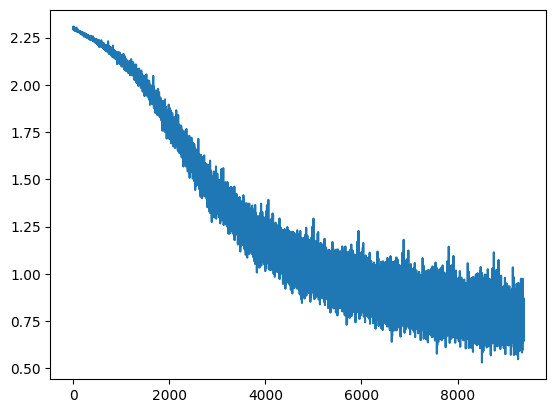

In [8]:
import matplotlib.pyplot as plt

lista_combinada = [item for sublist in loss_total for item in sublist]
len_lista_combinada = len(lista_combinada)
plt.plot(lista_combinada)

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [11]:
# Next steps:

# 1). Separar a montagem de rede neural parte a parte
# 2). Estudar parte a parte
# 3). Ler o Github inicial que comecei sobre isso
# 4). Escolher 3 a 4 papers de 2019 para implementar.